In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import GPy
import pickle

plt.style.use('hfs')

def sampled_LC_params(t, V, alpha=0.01):
    _mag_interp=V
    _time_interp = t

    _ind_tmax=_mag_interp.argmax()
    t_max = _time_interp[_ind_tmax]
    ax1.plot(_time_interp, _mag_interp, c='k', label='GP', alpha=alpha)
    
    x_30_40 = np.atleast_2d(np.array([30, 40])).T
    mag_30_40, __ = m.predict(x_30_40)

    # DELTA MAG 40 30
    dm_40_30 = (mag_30_40[1]-mag_30_40[0])
    ax1.axvline(_time_interp[_ind_tmax],c='k', label='t_max', alpha=alpha)
    ax1.axvline(x_30_40[0],c='k', ls=':', alpha=alpha)
    ax1.axvline(x_30_40[1],c='k', ls=':', alpha=alpha)

    ### FIRST DERIVATIVE 
    grad1 = np.gradient(_mag_interp)[_ind_tmax:] # after max
    ax2.plot(_time_interp, np.gradient(_mag_interp),lw=1, color='r', ls='--', alpha=alpha)
    ax2.plot(_time_interp[_ind_tmax:], grad1, color='r', alpha=alpha)

    # need second derivative to get the maximum
    grad2 = np.gradient(grad1) # important to not cut V_interp otherwise fucked

    # this finds the locations where grad2 goes from positive to negative - indicating peaks in grad1
    argmax_grad1 = [False] + [True if grad2[i]<0 and grad2[i-1]>0  else False for i in np.arange(1,grad2.shape[0])]
    t_dm1 = _time_interp[_ind_tmax:][argmax_grad1][0]

    # plotting location of t_dm1
    ax2.axvline(t_dm1, c='darkred', lw=1, alpha=alpha)
    ax1.axvline(t_dm1, c='darkred',  ls=':',label='t_dm1', alpha=alpha)

    ### SECOND DERIVATIVE 
    ax3.plot(_time_interp[1:], np.gradient(np.gradient(_mag_interp))[1:],lw=1,  
             color='b', ls='--', alpha=alpha)
    ax3.plot(_time_interp[_ind_tmax:], grad2, color='b', alpha=alpha)
    grad3 = np.gradient(grad2)
    argmin_grad2 = [False] + [True if grad3[i]>0 and grad3[i-1]<0  else False for i in np.arange(1,grad3.shape[0])]
    t_dm2 = _time_interp[_ind_tmax:][argmin_grad2][0]
    ax3.axvline(t_dm2, c='cornflowerblue', lw=1, alpha=alpha)
    ax1.axvline(t_dm2, c='cornflowerblue', ls='--', label='t_dm2', alpha=alpha)
    
    return t_max, t_dm1-t_max, t_dm2-t_max, dm_40_30[0]


In [30]:
data = pd.read_csv('../Data/IIb_clean_sample.dat', index_col=0)
data.event.unique()

array(['SN2008ax', 'SN2011dh', 'SN1993J', 'SN2006T', 'SN2004ex',
       'SN2008aq', 'SN2013df', 'SN2006el'], dtype=object)

In [31]:
sn='SN1993J'
data=data[data.event==sn].drop('event',axis=1)

In [32]:
results=pd.read_csv('params_best_GP_IIb.dat', index_col=0)

In [33]:
t_norm = data.MJD.values - data.texp.iloc[0]

t_exp = 0
y=np.atleast_2d(data.V).T
X=np.atleast_2d(t_norm).T

err = data.Verr
err = err.replace(np.nan,0).values

length_scale=np.mean(t_norm) 
variance=np.sqrt(np.std(t_norm))
                 
k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=length_scale)
#noise = GPy.kern.White(1, GPy.util.linalg.tdot(err)) + GPy.kern.Bias(1, GPy.util.linalg.tdot(err))
kernel = k 

In [34]:
mask = (t_norm>5)  

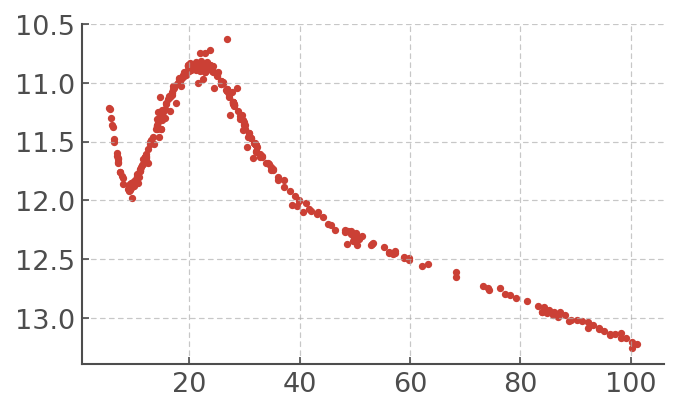

In [35]:
plt.scatter(t_norm[mask], y[mask])
plt.gca().invert_yaxis()

In [36]:
t_norm, y = t_norm[mask], y[mask]
X=np.atleast_2d(t_norm).T

In [37]:
x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),200)).T

In [38]:
n=100

In [39]:
m = GPy.models.GPRegression(X,y,kernel)
__ = m.optimize ()
__ = m.optimize_restarts (num_restarts = n , parallel = True, verbose=False)

(14.0, 10.0)

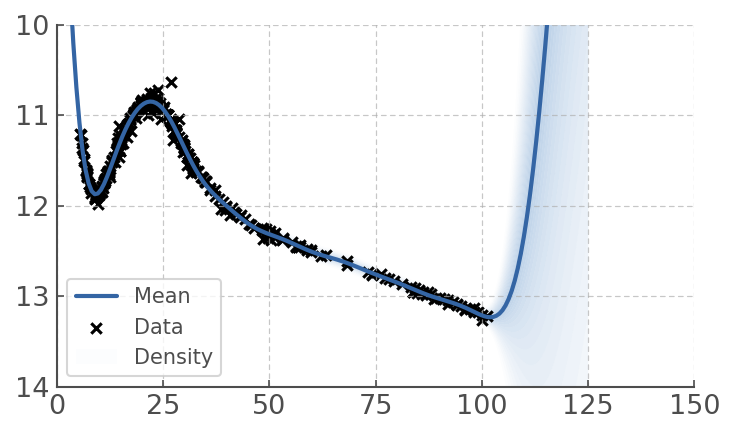

In [40]:
m.plot(plot_density=True)
plt.gca().invert_yaxis()
plt.xlim([0,150])
plt.ylim([14,10])

In [41]:
m

GP_regression.,value,constraints,priors
rbf.variance,76.16054519366902,+ve,
rbf.lengthscale,11.321431812821391,+ve,
Gaussian_noise.variance,0.0021705375320179416,+ve,


In [42]:
_file = open(f'{sn}.gpym', 'wb')
pickle.dump(m, _file)
_file.close()

 /home/fste075/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning:Warning: converting a masked element to nan.


<ErrorbarContainer object of 3 artists>

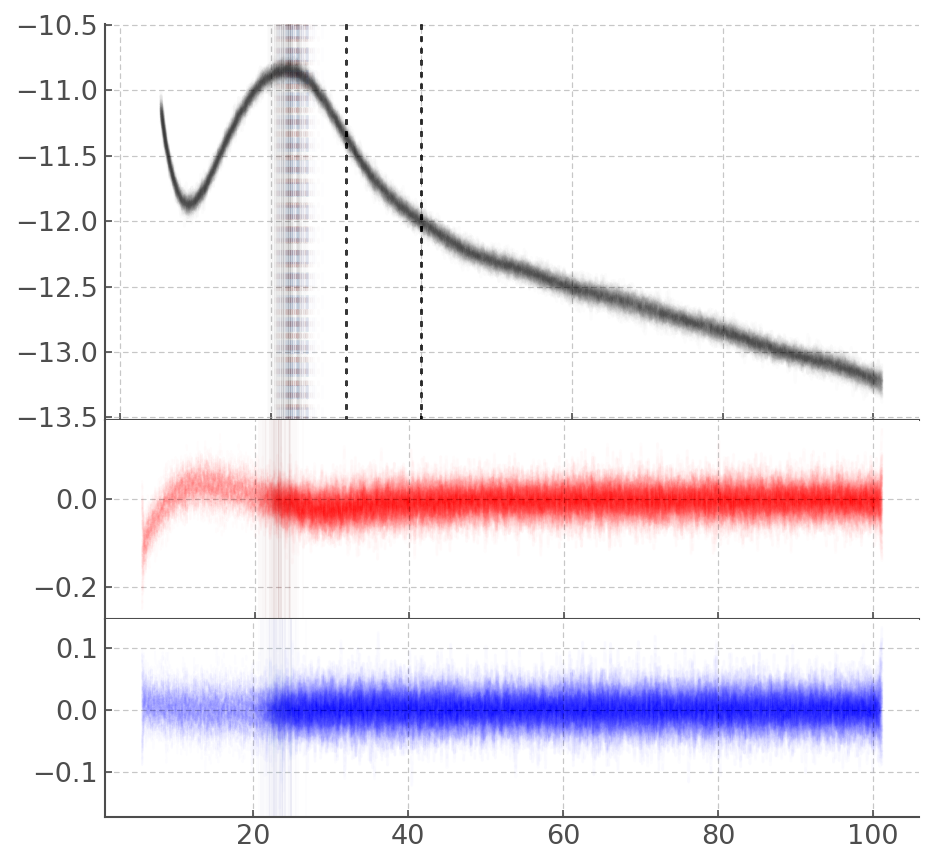

In [43]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])


list_params = []

t = np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_mag_interp, sigma = m.predict(t, full_cov=True)
_mag_interp=_mag_interp[:,0]*-1

test = np.random.multivariate_normal(_mag_interp,  sigma, size=100)
for i in range(test.shape[0]):
    _v_i = test[i,:]
    _params = sampled_LC_params(t=t[:,0], V=_v_i, alpha=0.01)
    list_params.append(list(_params))
    
ax1.errorbar(data.MJD-data.texp.iloc[0], data.V*-1, yerr = data.Verr, ls=' ', zorder=1000, color='crimson')

 /home/fste075/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning:Warning: converting a masked element to nan.


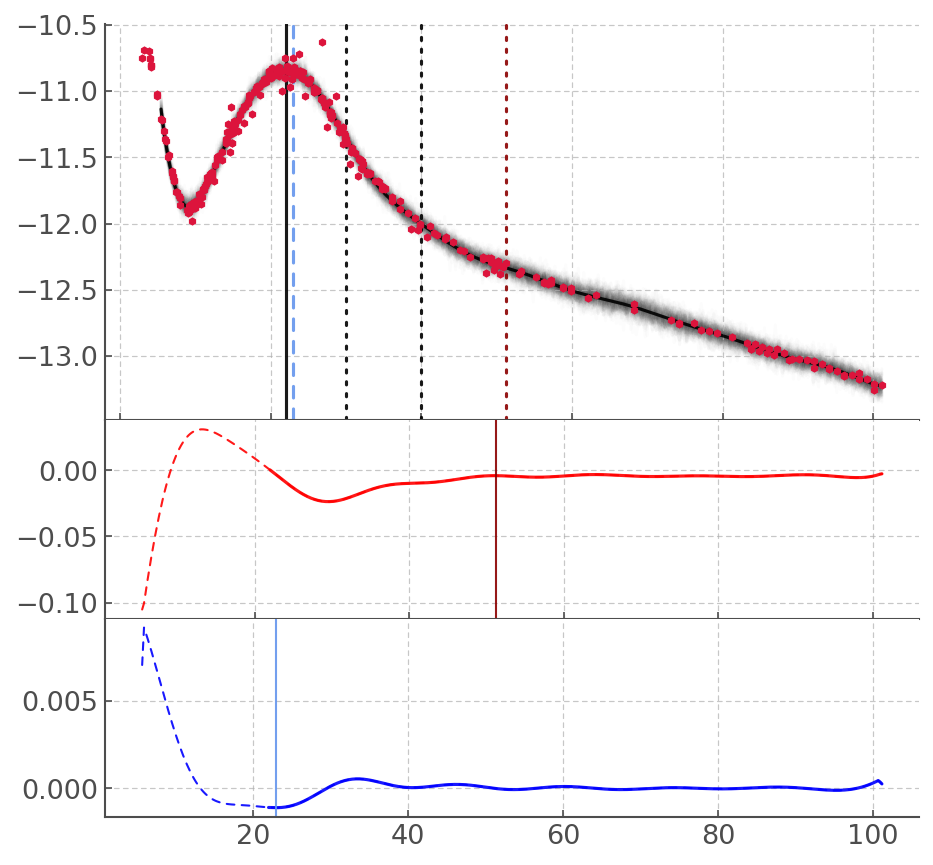

In [44]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])

t = np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_mag_interp, sigma = m.predict(t, full_cov=True)
_mag_interp=_mag_interp[:,0]*-1

_params = sampled_LC_params(t=t[:,0], V=_mag_interp, alpha=0.9)
    
    
ax1.errorbar(data.MJD-data.texp.iloc[0], data.V*-1, yerr = data.Verr, ls=' ',
             zorder=1000, color='crimson', marker='h', markersize=4)

test = np.random.multivariate_normal(_mag_interp,  sigma, size=100)
for i in range(test.shape[0]):
    _v_i = test[i,:]
    ax1.plot(t[:,0], _v_i, alpha=0.01, c='k', zorder=0.1)

In [45]:
results.loc[sn].iloc[0] = data.texp.iloc[0]
results.loc[sn].iloc[1:] = _params
results.to_csv('params_best_GP_IIb.dat')

In [46]:
results

,texp,trise,dm1,dm2,dm4030
event,,,,,
SN2008ax,54528.30,20.012331,34.884962,42.030075,0.664096
SN2011dh,55712.40,18.502968,36.534687,41.649543,0.728440
SN1993J,49073.05,21.999624,29.261654,0.959398,0.648006
SN2006T,NaN,NaN,NaN,NaN,NaN
SN2004ex,NaN,NaN,NaN,NaN,NaN
SN2008aq,NaN,NaN,NaN,NaN,NaN
SN2013df,NaN,NaN,NaN,NaN,NaN
SN2006el,NaN,NaN,NaN,NaN,NaN


In [47]:
_file = open(f'{sn}.gpym', 'wb')
pickle.dump(m, _file)
_file.close()

## SKLEARN

In [48]:
from sklearn import gaussian_process as sklgp

results_SKL=pd.read_csv('params_best_GP_IIb_SKL.dat', index_col=0)

def sampled_LC_params(m, t, alpha=0.01, ax1 = None, ax2 = None, ax3 = None, size=100):
    
    try:
        _mag_interp, sigma = m.predict(t, full_cov=True) # GPy implementation
        _mag_interp=_mag_interp[:,0]*-1
    except TypeError:
        _mag_interp, sigma = m.predict(t, return_cov=True) # sklearn implementation
        _mag_interp=_mag_interp*-1
    
    _time_interp = t[:,0]

    _ind_tmax=_mag_interp.argmax()
    t_max = _time_interp[_ind_tmax]

    ax1.plot(_time_interp, _mag_interp*-1, c='k', label='GP', alpha=alpha, zorder=10000)
    
    
    x_30 = np.atleast_2d(np.array([30])).T
    x_40 = np.atleast_2d(np.array([40])).T

    mag_30 =  m.predict(x_30)
    mag_40 =  m.predict(x_40)

    # DELTA MAG 40 30
    dm_40_30 = (mag_40-mag_30)
    ax1.axvline(_time_interp[_ind_tmax],c='grey', lw=1, alpha=alpha, label='t$_{max}$')
    ax1.axvline(x_30,c='k', ls=':', alpha=0.5, label='+30 days')
    ax1.axvline(x_40,c='k', ls=':', alpha=0.8, label='+40 days')

    ### FIRST DERIVATIVE 
    grad1 = np.gradient(_mag_interp)[_ind_tmax:] # after max
    ax2.plot(_time_interp, np.gradient(_mag_interp),lw=1, color='r', ls='--', alpha=alpha)
    ax2.plot(_time_interp[_ind_tmax:], grad1, color='r', alpha=alpha)

    # need second derivative to get the maximum
    grad2 = np.gradient(grad1) # important to not cut V_interp otherwise fucked

    # this finds the locations where grad2 goes from positive to negative - indicating peaks in grad1
    argmax_grad1 = [False] + [True if grad2[i]<0 and grad2[i-1]>0  else False for i in np.arange(1,grad2.shape[0])]
    t_dm1 = _time_interp[_ind_tmax:][argmax_grad1][0]

    # plotting location of t_dm1
    ax2.axvline(t_dm1, c='darkred', lw=1, alpha=alpha)
    ax1.axvline(t_dm1, c='darkred',  ls=':', alpha=alpha, label='dm1')

    ### SECOND DERIVATIVE 
    ax3.plot(_time_interp[1:], np.gradient(np.gradient(_mag_interp))[1:],lw=1,  
             color='b', ls='--', alpha=alpha)
    ax3.plot(_time_interp[_ind_tmax:], grad2, color='b', alpha=alpha)
    grad3 = np.gradient(grad2)
    argmin_grad2 = [False] + [True if grad3[i]>0 and grad3[i-1]<0  else False for i in np.arange(1,grad3.shape[0])]
    t_dm2 = _time_interp[_ind_tmax:][argmin_grad2][0]
    ax3.axvline(t_dm2, c='cornflowerblue', lw=1, alpha=alpha)
    ax1.axvline(t_dm2, c='cornflowerblue', ls='--',  alpha=alpha, label='dm2')
    
    ## Sampling to show uncertianties
    test = np.random.multivariate_normal(_mag_interp,  sigma, size=size)
    for i in range(test.shape[0]):
        _v_i = test[i,:]
        ax1.plot(_time_interp , _v_i*-1, alpha=0.01, zorder=0.1, color='k')
        _grad1 = np.gradient(_v_i)
        ax2.plot(_time_interp, _grad1, color='r', alpha=0.01)
        _grad2 = np.gradient(_grad1)
        ax3.plot(_time_interp, _grad2, color='b', alpha=0.01)
    
    return t_max, t_dm1-t_max, t_dm2-t_max, dm_40_30[0]

In [49]:
t_norm = data.MJD.values - data.texp.iloc[0]
t_exp = 0

y=data.V.values
X=np.atleast_2d(t_norm).T

err = data.Verr.values
                 
k_rbf = sklgp.kernels.RBF(length_scale_bounds=(1,200)) 
k_matern = sklgp.kernels.Matern(length_scale_bounds=(1,1000), nu=1.5) 
k_white = sklgp.kernels.WhiteKernel(0.1)
k_rq = sklgp.kernels.RationalQuadratic(length_scale_bounds=(1,100), alpha=0.2) 


In [50]:
k1 = sklgp.kernels.RationalQuadratic(length_scale=60) 
k2 = sklgp.kernels.RationalQuadratic(length_scale=20) 

In [51]:
kernel = k1 + k2 

In [52]:
gp = sklgp.GaussianProcessRegressor(kernel=k1+k_white, n_restarts_optimizer=100, normalize_y=False)
gp.fit(X, y)

 /home/fste075/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=60) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=100)

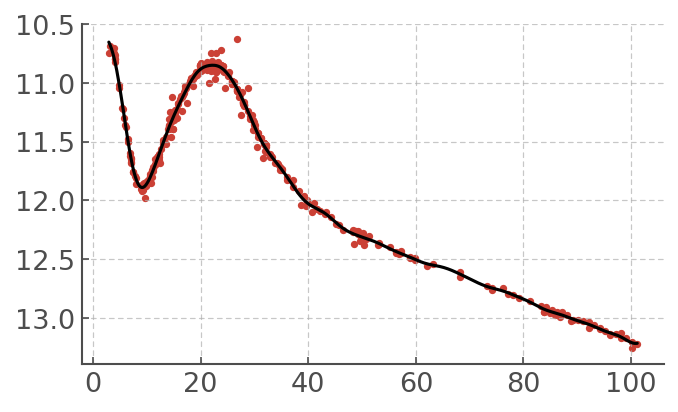

In [53]:
x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T
_mag_interp, sigma = gp.predict(x, return_std=True)
_time_interp = x.T[0]

plt.plot(x, _mag_interp, c='k', label='GP')
plt.scatter(t_norm, y, label='data')
plt.gca().invert_yaxis()

 /home/fste075/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning:Warning: converting a masked element to nan.


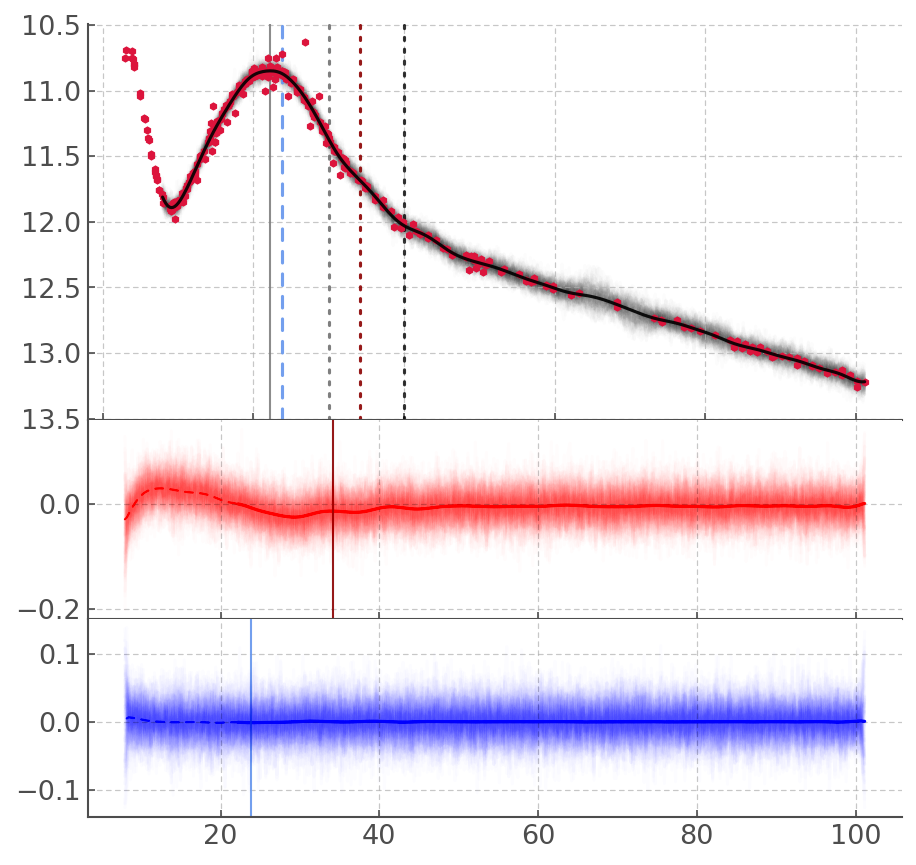

In [54]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])

t = np.atleast_2d(np.linspace(t_norm.min()+5, t_norm.max(),400)).T

_mag_interp, sigma = gp.predict(x, return_cov=True)
_time_interp = x.T[0]

_mag_interp=_mag_interp[:]

_params = sampled_LC_params(t=t, m=gp, alpha=0.9, ax1=ax1, ax2=ax2, ax3=ax3)
    
ax1.errorbar(data.MJD-data.texp.iloc[0], data.V, yerr = data.Verr, ls=' ',
             zorder=1000, color='crimson', marker='h', markersize=4)

ax1.invert_yaxis()

In [55]:
results_SKL.loc[sn].iloc[0] = data.texp.iloc[0]
results_SKL.loc[sn].iloc[1:] = _params
results_SKL.to_csv('params_best_GP_IIb_SKL.dat')

In [56]:
results_SKL

,texp,trise,dm1,dm2,dm4030
event,,,,,
SN2008ax,54528.30,21.693534,3.782707,0.840602,0.641308
SN2011dh,NaN,NaN,NaN,NaN,NaN
SN1993J,49073.05,22.198622,11.912782,1.635088,0.658547
SN2006T,NaN,NaN,NaN,NaN,NaN
SN2004ex,NaN,NaN,NaN,NaN,NaN
SN2008aq,NaN,NaN,NaN,NaN,NaN
SN2013df,NaN,NaN,NaN,NaN,NaN
SN2006el,NaN,NaN,NaN,NaN,NaN
